In [6]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import requests
from PIL import Image

In [7]:
#Using VGG-19 pretrained model for image classification

model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

In [8]:
def download(url,fname):
    response = requests.get(url)
    with open(fname,"wb") as f:
        f.write(response.content)
    
# Downloading the image    
download("https://specials-images.forbesimg.com/imageserve/5db4c7b464b49a0007e9dfac/960x0.jpg?fit=scale","input.jpg")

# Opening the image
img = Image.open('input.jpg') 

In [9]:
# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

'''
    Y = (X - μ)/(σ) => Y ~ Distribution(0,1) if X ~ Distribution(μ,σ)
    => Y/(1/σ) follows Distribution(0,σ)
    => (Y/(1/σ) - (-μ))/1 is actually X and hence follows Distribution(μ,σ)
'''
def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [10]:
# preprocess the image
X = preprocess(img)
X

tensor([[[[-0.2513, -0.3369, -0.4397,  ..., -0.6623, -0.6794, -0.6965],
          [-0.2856, -0.3541, -0.4397,  ..., -0.6452, -0.6623, -0.6794],
          [-0.3369, -0.3883, -0.4739,  ..., -0.6109, -0.6281, -0.6452],
          ...,
          [ 0.4337, -1.2617, -0.8335,  ..., -0.9877, -1.1075, -1.2445],
          [ 0.3994, -1.3815, -0.6109,  ..., -0.9363, -1.0390, -1.3302],
          [ 0.4166, -1.2445, -0.8678,  ..., -0.9363, -1.0048, -1.3130]],

         [[-0.0049, -0.0224, -0.0399,  ...,  0.0826,  0.0651,  0.0476],
          [ 0.0126, -0.0049, -0.0049,  ...,  0.1001,  0.0826,  0.0651],
          [ 0.0126,  0.0301,  0.0301,  ...,  0.1001,  0.0826,  0.0476],
          ...,
          [ 0.8529, -0.6527, -0.2325,  ..., -0.1450, -0.2150, -0.3725],
          [ 0.8004, -0.7402, -0.0399,  ..., -0.0574, -0.1275, -0.4426],
          [ 0.8529, -0.6001, -0.3375,  ..., -0.0224, -0.0749, -0.4251]],

         [[-1.2816, -1.3164, -1.3687,  ..., -1.5779, -1.5953, -1.6127],
          [-1.3164, -1.3513, -

In [14]:
X.size()

torch.Size([1, 3, 224, 224])

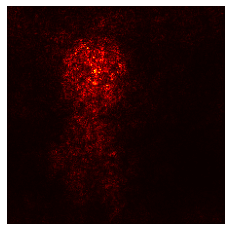

In [5]:
# we would run the model in evaluation mode
model.eval()

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad_()

'''
forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
and we also don't need softmax, we need scores, so that's perfect for us.
'''

scores = model(X)

# Get the index corresponding to the maximum score and the maximum score itself.
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]

'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(X.grad.data.abs(),dim=1)

# code to plot the saliency map as a heatmap
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()